<h1> SIMA PROJECT </h1>

We are creating this project in 3 stages:-
1. Simple Logrank test
2. Weighted Logrank Test
3. Application 

<h1 style='color:Gray'> Stage 1  </h1>

<h1 style='color:Green'> Log Rank test.  </h1>


<p>A log-rank test is a statistical hypothesis test used to compare the survival times of two or more groups. It is commonly employed in survival analysis, particularly in medical research to assess whether there are significant differences in survival rates between different treatments or groups of individuals.

The test is based on the Kaplan-Meier estimator, which estimates the survival function for each group. The log-rank test then compares the observed number of events (such as deaths or failures) in each group with the number of events expected if there were no difference between the groups. The test calculates a test statistic that follows a chi-square distribution under the null hypothesis of no difference in survival times.</p>
<p>
We make a null hypothesis that all groups under study follow a similar survival distribution. We at every time point calculate a statistic (O-E)/(sqrt(v)) where O is the observed number of failiures at a time point. E is the expected number of failiures at that time point. V is the vairance of deaths among groups at a time point. The statistic follows a chi square distribution. In accordance with the p-value desired, we compute a chi-critical. On comparing a chi-square statistic with this chi-critical we can tell if our null hypothesis will be rejected or accepted
</p>

<h3 style='color:Gray'> Importing packages</h3>

In [1]:
import numpy as np
import pandas as pd
import math
import itertools
from scipy.stats import expon, norm, mannwhitneyu
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.preprocessing import StandardScaler

<h3 style='color:Gray'>Implementing the Log-Rank test from scratch for an example</h3>

The below data is about survival data of a population of size 10. The population is equally split into male and female populations. We have 6 time labels : 4,6,11,15,20,25 . The data involves right censoring of 3 observations as they are alive at the end of the period of study.

In [2]:
data_observed = {
    'Time_Label': [4,6,11,15,20,25],
    'Male Population at Risk':[5,4,2,2,0,0],
    'Female Population at Risk':[5,5,5,4,4,2],
    'Total Population at Risk':[10,9,7,6,4,2],
    'Observed_Male_Deaths': [1,1,0,2,0,0],
    'Observed_Female_Deaths': [0,0,1,0,1,1],
    'Observed_Total_Deaths': [1,1,1,2,1,1],
    'Expected Male Deaths':[0.5,0.444,0.286,0.667,0,0],
    'Expected Female Deaths':[0.5,0.556,0.714,1.333,1,1]
}
df=pd.DataFrame(data_observed)
df.head()

# The log-rank formula
res=0

res=res+math.pow((df['Observed_Male_Deaths'].sum())-(df['Expected Male Deaths'].sum()),2)/(df['Expected Male Deaths'].sum())
res=res+math.pow((df['Observed_Female_Deaths'].sum())-(df['Expected Female Deaths'].sum()),2)/(df['Expected Female Deaths'].sum())

print(res)

3.19803848832139


<h3 style='color:Gray'> Inferences drawn from the above implementation - Explanation of Log-rank and Hypothesis Test</h3>

<h4 style='color:Gray'>Univariate Data Comparision between various synthetic datasets (Exponential, Lognormal, Weibull and Gamma)</h4>

In [3]:
def generate_survival_data(size, distribution):
    if distribution == 'exponential':
        return np.random.exponential(scale=1, size=size)
    elif distribution == 'weibull':
        return np.random.weibull(a=1, size=size)
    elif distribution == 'lognormal':
        return np.random.lognormal(mean=0, sigma=1, size=size)
    elif distribution == 'gamma':
        return np.random.gamma(shape=2, scale=1, size=size)
    else:
        raise ValueError("Invalid distribution")

Dataset size: 150, Distribution comparison: exponential vs weibull
p-value: 0.8640569449361009


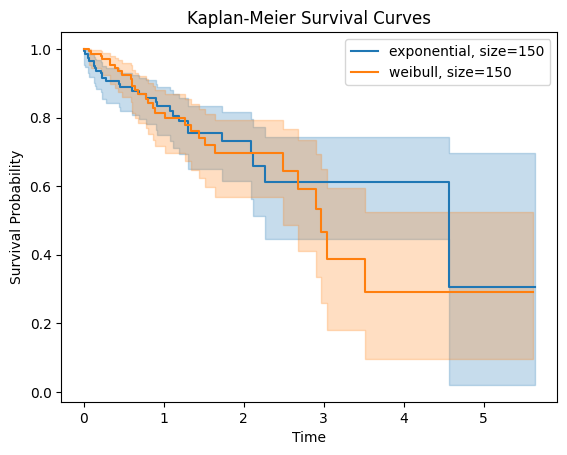

Dataset size: 150, Distribution comparison: exponential vs lognormal
p-value: 0.21972826724848665


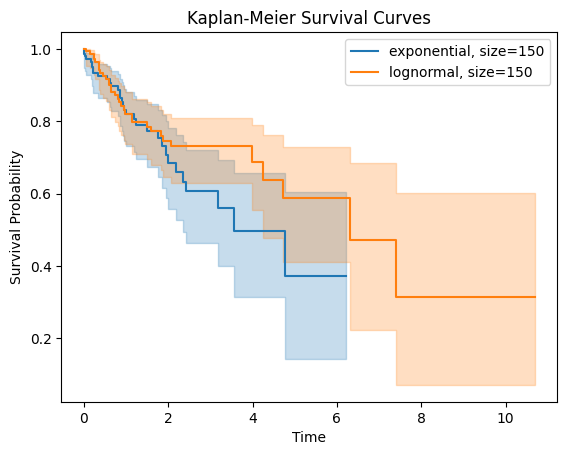

Dataset size: 150, Distribution comparison: weibull vs lognormal
p-value: 0.20095871877847754


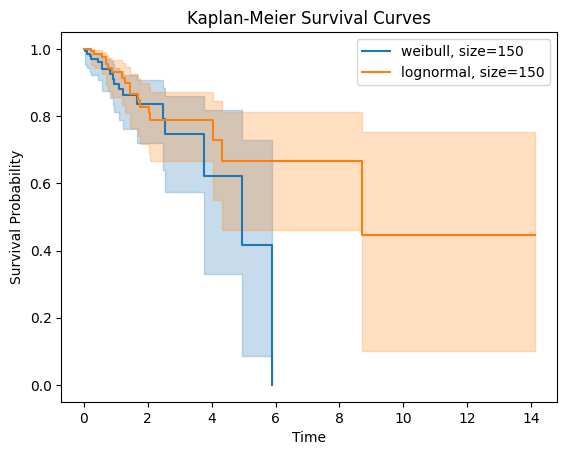

Dataset size: 200, Distribution comparison: exponential vs weibull
p-value: 0.9304935849850947


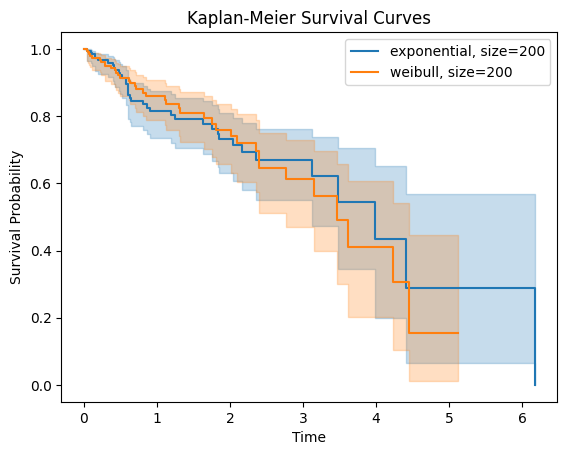

Dataset size: 200, Distribution comparison: exponential vs lognormal
p-value: 0.17830590800688928


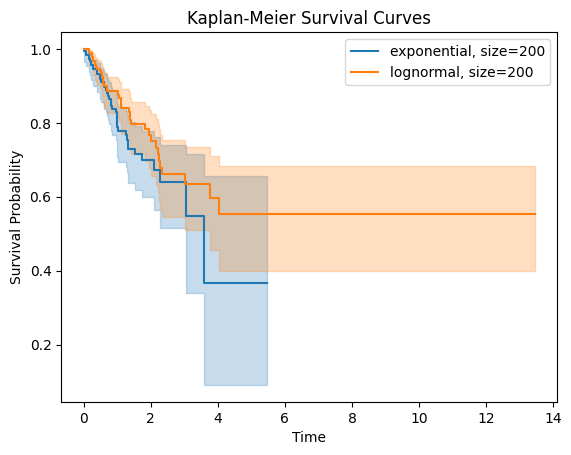

Dataset size: 200, Distribution comparison: weibull vs lognormal
p-value: 0.05388427499321917


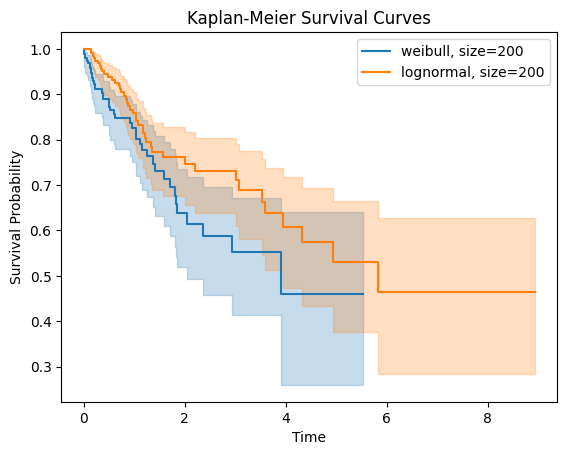

In [4]:
dataset_sizes = [150, 200]  
distributions = ['exponential', 'weibull', 'lognormal']  # Different distributions

# Generate synthetic datasets
for size in dataset_sizes:
    for dist1, dist2 in itertools.combinations(distributions, 2):
        data1 = generate_survival_data(size, dist1)
        data2 = generate_survival_data(size, dist2)
        
        # Assuming 20% censoring for both datasets
        censored_data = np.random.choice([True, False], size=size, p=[0.2, 0.8])

        df1 = pd.DataFrame({'Time': data1, 'Censored': censored_data})
        df2 = pd.DataFrame({'Time': data2, 'Censored': censored_data})


        kmf1 = KaplanMeierFitter()
        kmf1.fit(df1['Time'], event_observed=df1['Censored'])

        kmf2 = KaplanMeierFitter()
        kmf2.fit(df2['Time'], event_observed=df2['Censored'])


        kmf1.plot(label=f"{dist1}, size={size}")
        kmf2.plot(label=f"{dist2}, size={size}")


        results = logrank_test(df1['Time'], df2['Time'], event_observed_A=df1['Censored'], event_observed_B=df2['Censored'])
        print(f"Dataset size: {size}, Distribution comparison: {dist1} vs {dist2}")
        print(f"p-value: {results.p_value}")


        plt.legend()
        plt.xlabel('Time')
        plt.ylabel('Survival Probability')
        plt.title('Kaplan-Meier Survival Curves')
        plt.show()

<h3 style="color:Gray">Analysing Power for three distributions : exponential, weibull and lognormal</h3>

The power analysis of a statistical test assesses its ability to detect a true effect when it exists. In the context of survival analysis, the power of the log-rank test is particularly important as it determines the likelihood of correctly identifying differences in survival distributions between groups.

## Power of the Test

The power of the log-rank test is influenced by several factors, including the sample size, the hazard ratio (effect size), the level of censoring, and the chosen significance level (alpha). It is defined as the probability of rejecting the null hypothesis (no difference in survival distributions) when it is false.

## Formula

The power of the log-rank test can be calculated using the following formula:

$$ \text{Power} = P(\text{Reject } H_0 | H_1 \text{ is true}) $$

Where:
- \( H_0 \): Null hypothesis (no difference in survival distributions)
- \( H_1 \): Alternative hypothesis (difference in survival distributions)
- \( P \): Probability
- "Reject \( H_0 \)": Reject the null hypothesis

Power is closely related to the concept of a type II error, also known as false negative.
$$ \text{Power} = 1 -  \text{ probability of type II error} $$

## Interpretation

A higher power value indicates a greater ability of the test to detect differences in survival distributions when they truly exist. Conversely, a lower power value suggests a higher risk of failing to detect true differences, leading to a Type II error (false negative).

## Implementation

In this section, we will conduct a power analysis of the log-rank test by simulating survival data of the 3 distributions and estimating the power of the test for each scenario.

In [5]:
def calculate_power(n_simulations, n_samples, hazard_ratio, alpha,flag):
    power = 0  
    p_values = []
    for i in range(n_simulations):
        if(flag==1):
            surv1 = np.random.lognormal(mean=np.log(hazard_ratio),sigma=1, size=n_samples)
            surv2 = np.random.weibull(hazard_ratio, size=n_samples)
        elif(flag==2):
            surv1 = np.random.lognormal(mean=np.log(1.1),sigma=1, size=n_samples)
            surv2 = np.random.exponential(scale=1/hazard_ratio, size=n_samples)
        else:
            surv1 = np.random.exponential(scale=1/hazard_ratio, size=n_samples)
            surv2 = np.random.weibull(hazard_ratio, size=n_samples)
        
        censored_data = np.random.choice([True, False], size=n_samples, p=[0.2, 0.8])

        df1 = pd.DataFrame({'Time': surv1, 'Censored': censored_data})
        df2 = pd.DataFrame({'Time': surv2, 'Censored': censored_data})
        #print(df1)
        # Log-rank test
        results = logrank_test(df1['Time'], df2['Time'], event_observed_A=df1['Censored'], event_observed_B=df2['Censored'])

        # Check if null hypothesis is rejected
        if results.p_value < alpha:
            power += 1
        p_values.append(results.p_value)
    return power / n_simulations

In [6]:
n_simulations = 1000 
n_samples = 100
hazard_ratio = 1.5 
alpha = 0.05

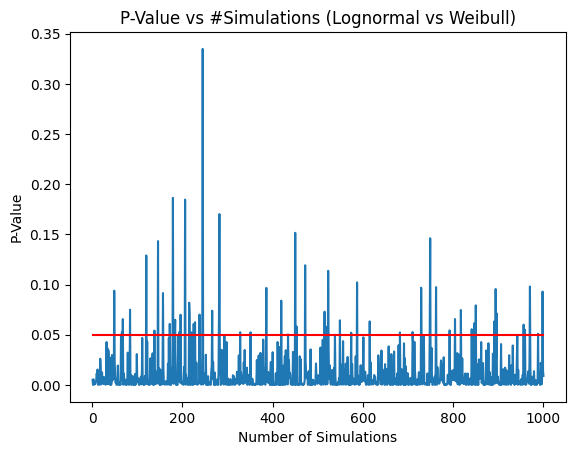

Power of Log-Rank Test : 94.1 %


In [7]:
# lognormal v/s Weibull
p_values = []
power = calculate_power(n_simulations, n_samples, hazard_ratio, alpha,1)
x=np.linspace(1,n_simulations,n_simulations)
y=[0.05 for _ in range(1000)]
plt.plot(x,p_values)
plt.plot(x,y,color='r')
plt.xlabel('Number of Simulations')
plt.ylabel('P-Value')
plt.title('P-Value vs #Simulations (Lognormal vs Weibull)')
plt.show()
print(f"Power of Log-Rank Test : {round(power*100,3)} %")

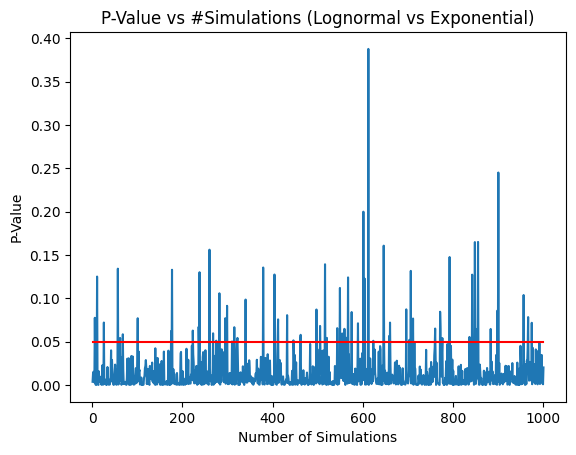

Power of Log-Rank Test : 93.1 %


In [8]:
# Lognormal v/s Exponential
p_values = []
power = calculate_power(n_simulations, n_samples, hazard_ratio, alpha,2)
x=np.linspace(1,n_simulations,n_simulations)
y=[0.05 for _ in range(1000)]
plt.plot(x,p_values)
plt.plot(x,y,color='r')
plt.xlabel('Number of Simulations')
plt.ylabel('P-Value')
plt.title('P-Value vs #Simulations (Lognormal vs Exponential)')
plt.show()
print(f"Power of Log-Rank Test : {round(power*100,3)} %")

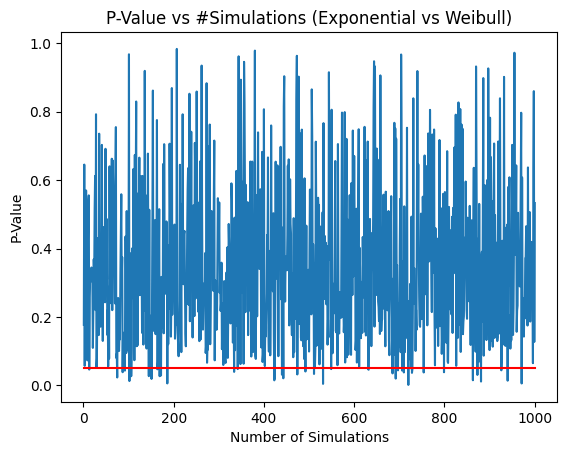

Power of Log-Rank Test : 4.3 %


In [9]:
# Exponential v/s Weibull
p_values = []
power = calculate_power(n_simulations, n_samples, hazard_ratio, alpha,3)
x=np.linspace(1,n_simulations,n_simulations)
y=[0.05 for _ in range(1000)]
plt.plot(x,p_values)
plt.plot(x,y,color='r')
plt.xlabel('Number of Simulations')
plt.ylabel('P-Value')
plt.title('P-Value vs #Simulations (Exponential vs Weibull)')
plt.show()
print(f"Power of Log-Rank Test : {round(power*100,3)} %")

<h3 style="color:Gray">Efficiency of two tests - Logrank and Wilcoxon (for Exponential and Weibull distributions)</h3>

### Difference between Wilcoxon Rank-Sum Test and Log-Rank Test

1. **Wilcoxon Rank-Sum Test (or Mann-Whitney U Test)**:
   - The Wilcoxon rank-sum test is a non-parametric test used to assess whether two independent samples come from populations with the same distribution.
   - It is commonly used when the assumptions of the t-test (such as normality and homogeneity of variances) are not met.
   - It focuses on comparing the distribution of observations between two groups without considering the time-to-event data.
   - It's often used in scenarios where you have two groups and you want to determine if one tends to have higher (or lower) values than the other.

2. **Log-Rank Test**:
   - The log-rank test is a hypothesis test used to compare the survival distributions of two or more groups.
   - It is commonly used in survival analysis to determine if there is a significant difference in survival experience between two or more groups over time.
   - The log-rank test assesses whether the observed number of events (such as deaths) differs significantly between groups, while accounting for the censoring (i.e., individuals who have not experienced the event by the end of the study).
   - It's used when you have survival data (time-to-event data) and you want to compare the survival curves of different groups.

In summary, while both tests are used to compare groups, the Wilcoxon rank-sum test compares the distributions of two groups' observations without considering time-to-event data, whereas the log-rank test compares survival distributions over time.


# Efficiency Comparison: Log-Rank Test vs. Wilcoxon Test

Efficiency comparison between statistical tests provides valuable insights into their relative performance in detecting differences in survival distributions. In this section, we will compare the efficiency of the log-rank test with that of the Wilcoxon test, also known as the Mann-Whitney U test.

## Efficiency

Efficiency is defined as the ratio of the power of one test to the power of another test under the same conditions. In this context, the efficiency of the log-rank test compared to the Wilcoxon test provides insights into their relative ability to detect differences in survival distributions.

Mathematically, the efficiency of the log-rank test compared to the Wilcoxon test can be expressed as:

$$ \text{Efficiency of Log-Rank Test} = \frac{\text{Power of Log-Rank Test}}{\text{Power of Wilcoxon Test}} $$

A higher efficiency value indicates that the log-rank test is more effective in detecting differences in survival distributions compared to the Wilcoxon test under the same conditions.

## Implementation

In this section, we will conduct a comparative analysis of the efficiency of the log-rank test by simulating survival data under exponential and weibull distributions and estimating their respective powers. We will then calculate the efficiency of the log-rank test relative to the Wilcoxon test to determine their relative performance in detecting differences in survival distributions.


In [10]:
# Function to calculate Efficiency between two tests - Logrank and Wilcoxon tests
def calculate_efficiency(n_simulations, n_samples, hazard_ratio, alpha):
    power_logrank = 0  
    power_wilcoxon = 0
    per_censoring = []
    for _ in range(n_simulations):
        surv1 = np.random.exponential(scale=1/hazard_ratio, size=n_samples)
        surv2 = np.random.weibull(hazard_ratio, size=n_samples)
        censored_data = np.random.choice([True, False], size=n_samples, p=[0.2, 0.8])
        percentage_censoring = np.mean(censored_data) * 100
        per_censoring.append(percentage_censoring)


        results_logrank = logrank_test(surv1, surv2, event_observed_A=censored_data, event_observed_B=censored_data)
        _, p_value_wilcoxon = mannwhitneyu(surv1[~censored_data], surv2[~censored_data], alternative='two-sided')

        if results_logrank.p_value < alpha:
            power_logrank += 1
        if p_value_wilcoxon < alpha:
            power_wilcoxon += 1
    
    efficiency = power_logrank / power_wilcoxon if power_wilcoxon != 0 else 0
    return efficiency

In [11]:
n_simulations = 1000  
n_samples = 200  
hazard_ratio = 1.825 
alpha = 0.05
per_censoring=[]

In [12]:
efficiency = calculate_efficiency(n_simulations, n_samples, hazard_ratio, alpha)
per_censoring = np.array(per_censoring)
print(f"Mean percentage of censoring: {np.mean(per_censoring):.2f}%")
print(f"Efficiency of Log-Rank Test compared to Wilcoxon Test: {round(efficiency*100,3)} %")

Mean percentage of censoring: 20.00%
Efficiency of Log-Rank Test compared to Wilcoxon Test: 81.2 %


# Inferences from Power Comparison

The power comparison between the log-rank test and the Wilcoxon test provides valuable insights into their relative effectiveness in detecting differences in survival distributions. Based on the results of the power comparison, we can draw several inferences:

1. **Relative Performance**: The efficiency analysis reveals which test performs better in detecting differences in survival distributions under the same conditions. A higher efficiency value suggests that the log-rank test is more effective than the Wilcoxon test in detecting such differences.

2. **Sensitivity**: A higher power value indicates greater sensitivity to detect true differences in survival distributions. Therefore, a test with higher power is preferred as it minimizes the risk of false negatives (Type II errors).

3. **Suitability**: The choice between the log-rank test and the Wilcoxon test depends on various factors such as the study design, distribution of survival times, and level of censoring. The power comparison can guide researchers in selecting the most appropriate test for their specific scenario.

4. **Robustness**: If the log-rank test consistently demonstrates higher power across different scenarios, it may be considered a more robust choice for comparing survival distributions, especially when the proportional hazards assumption is met.

5. **Further Investigation**: In cases where the power comparison reveals similar performance between the two tests, further investigation into the underlying assumptions and limitations of each test may be warranted to make an informed choice.

Overall, the power comparison provides valuable guidance for researchers in selecting the most suitable statistical test for analyzing survival data and drawing meaningful conclusions from their studies.

## Real World Data 

### Survival Covid Data

In [14]:
data = pd.read_csv("SurvivalCovid.csv")
data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0


In [15]:
data.loc[data.status==1, 'dead']=0
data.loc[data.status==2, 'dead']=1

data.head()

,Unnamed: 0,inst,time,status,age,sex,ph.ecog,ph.karno,pat.karno,meal.cal,wt.loss,dead
0,1,3.0,306,2,74,1,1.0,90.0,100.0,1175.0,NaN,1.0
1,2,3.0,455,2,68,1,0.0,90.0,90.0,1225.0,15.0,1.0
2,3,3.0,1010,1,56,1,0.0,90.0,90.0,NaN,15.0,0.0
3,4,5.0,210,2,57,1,1.0,90.0,60.0,1150.0,11.0,1.0
4,5,1.0,883,2,60,1,0.0,100.0,90.0,NaN,0.0,1.0


In [16]:
kmf_m=KaplanMeierFitter()
kmf_f=KaplanMeierFitter()

Male=data.query("sex==1")
Female=data.query("sex==2")

kmf_m.fit(durations=Male["time"],event_observed=Male["dead"],label="Male")
kmf_f.fit(durations=Female["time"],event_observed=Female["dead"],label="Female")

<lifelines.KaplanMeierFitter:"Female", fitted with 90 total observations, 37 right-censored observations>

In [17]:
kmf_m.event_table

,removed,observed,censored,entrance,at_risk
event_at,,,,,
0.0,0,0,0,138,138
11.0,3,3,0,0,138
12.0,1,1,0,0,135
13.0,2,2,0,0,134
15.0,1,1,0,0,132
...,...,...,...,...,...
814.0,1,1,0,0,5
840.0,1,0,1,0,4
883.0,1,1,0,0,3


Text(0.5, 1.0, 'KMF')

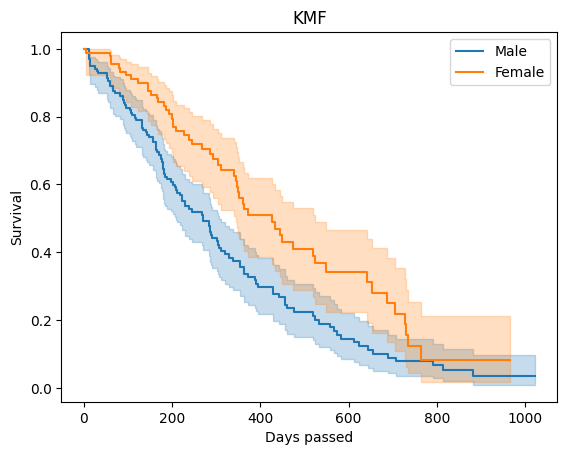

In [18]:
kmf_m.plot()
kmf_f.plot()

plt.xlabel("Days passed")
plt.ylabel("Survival")
plt.title("KMF")

<Axes: xlabel='timeline'>

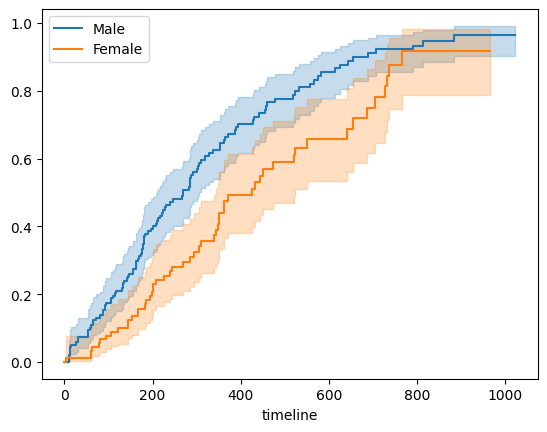

In [19]:
# plot cumulative density

kmf_m.plot_cumulative_density()
kmf_f.plot_cumulative_density()

In [20]:
Time0 = Male['time']
Event0 = Male['dead']

Time1 = Female['time']
Event1 = Female['dead']


result=logrank_test(Time0,Time1,event_observed_A=Event0,event_observed_B=Event1)
result.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          10.33 <0.005      9.57

#### Power for Survival Covid Data

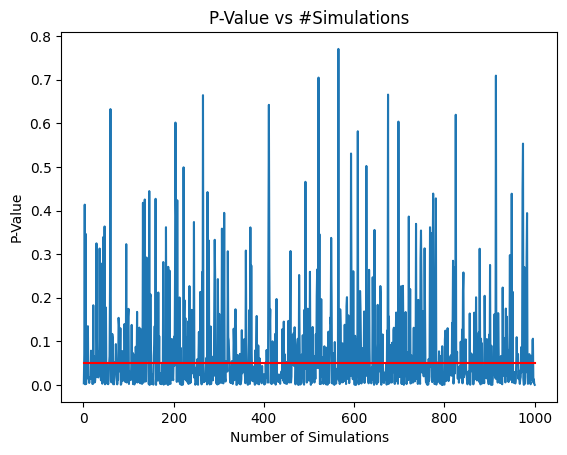

Power of Log-Rank Test : 58.4 %


In [21]:
power=0
p_values=[]
n_simulations=1000
for i in range(n_simulations):
    selected_rows = data.sample(n=100, replace=False)
    Male=selected_rows.query("sex==1")
    Female=selected_rows.query("sex==2")
    
    Time0 = Male['time']
    Event0 = Male['dead']

    Time1 = Female['time']
    Event1 = Female['dead']

    result=logrank_test(Time0,Time1,event_observed_A=Event0,event_observed_B=Event1)
    p_values.append(result.p_value)
    if result.p_value < 0.05:
        power += 1
power=power/n_simulations
x=np.linspace(1,n_simulations,n_simulations)
y=[0.05 for _ in range(1000)]
plt.plot(x,p_values)
plt.plot(x,y,color='r')
plt.xlabel('Number of Simulations')
plt.ylabel('P-Value')
plt.title('P-Value vs #Simulations')
plt.show()
print(f"Power of Log-Rank Test : {round(power*100,3)} %")   

### Heart Failure

In [22]:
data = pd.read_csv("heart_failure_clinical_records_dataset.csv")
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [23]:
data.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [24]:
kmf_n=KaplanMeierFitter()
kmf_s=KaplanMeierFitter()

non_smoker=data.query("smoking==0")
smoker=data.query("smoking==1")

kmf_n.fit(durations=non_smoker["time"],event_observed=non_smoker["DEATH_EVENT"],label="non_smoker")
kmf_s.fit(durations=smoker["time"],event_observed=smoker["DEATH_EVENT"],label="smoker")

<lifelines.KaplanMeierFitter:"smoker", fitted with 96 total observations, 66 right-censored observations>

Text(0.5, 1.0, 'KMF')

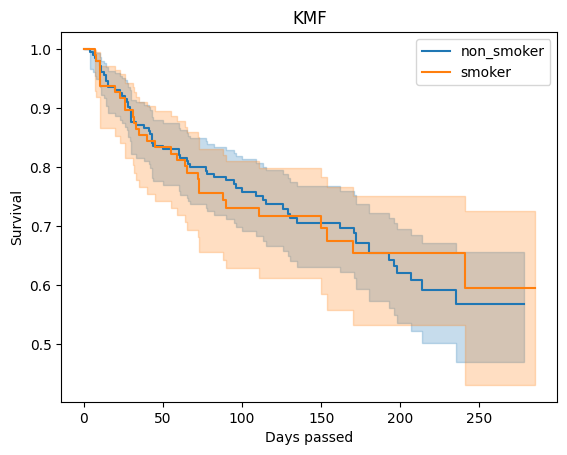

In [25]:
kmf_n.plot()
kmf_s.plot()

plt.xlabel("Days passed")
plt.ylabel("Survival")
plt.title("KMF")

Surprisingly, the above plot shows us that non-smokers tend to have a higher probability of survival initially but a lower survival for longer time horizons, compared to smokers!

<Axes: xlabel='timeline'>

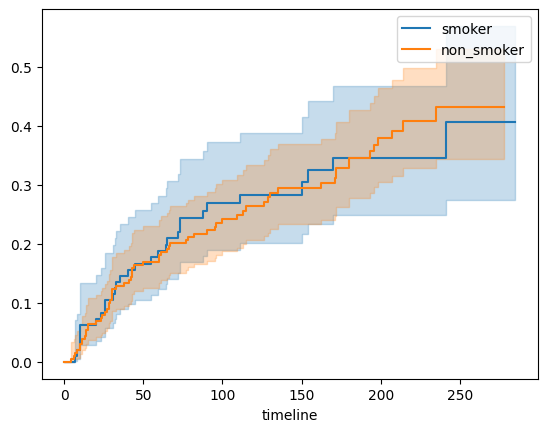

In [26]:
# plot cumulative density

kmf_s.plot_cumulative_density()
kmf_n.plot_cumulative_density()

In [27]:
Time0 = non_smoker['time']
Event0 = non_smoker['DEATH_EVENT']

Time1 = smoker['time']
Event1 = smoker['DEATH_EVENT']

result=logrank_test(Time0,Time1,event_observed_A=Event0,event_observed_B=Event1)

print(f'Test Statistic: {result.test_statistic}')
print(f'p-value: {result.p_value}')

Test Statistic: 0.0020417037767437793
p-value: 0.9639596778572339


#### Power for Heart Failure Data

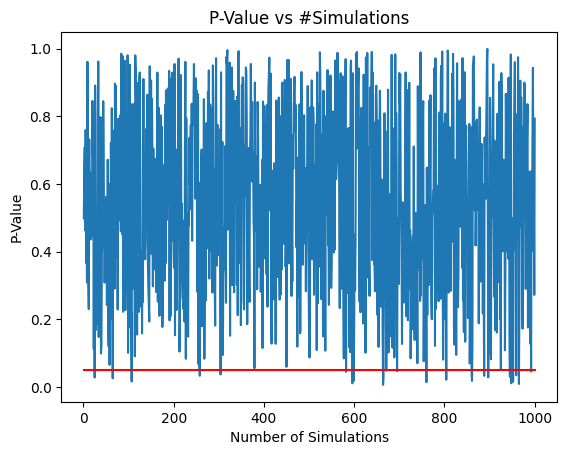

Power of Log-Rank Test : 2.5 %


In [28]:
power=0
p_values=[]
n_simulations=1000
for i in range(n_simulations):
    selected_rows = data.sample(n=100, replace=False)
    non_smoker=selected_rows.query("smoking==0")
    smoker=selected_rows.query("smoking==1")
    
    Time0 = non_smoker['time']
    Event0 = non_smoker['DEATH_EVENT']

    Time1 = smoker['time']
    Event1 = smoker['DEATH_EVENT']

    result=logrank_test(Time0,Time1,event_observed_A=Event0,event_observed_B=Event1)
    p_values.append(result.p_value)
    if result.p_value <0.05:
        power += 1
power=power/n_simulations
x=np.linspace(1,n_simulations,n_simulations)
y=[0.05 for _ in range(1000)]
plt.plot(x,p_values)
plt.plot(x,y,color='r')
plt.xlabel('Number of Simulations')
plt.ylabel('P-Value')
plt.title('P-Value vs #Simulations')
plt.show()
print(f"Power of Log-Rank Test : {round(power*100,3)} %")   

### Laser Eye Surgery With Diabitities

In [29]:
data = pd.read_csv("diabetic.csv")
data.head()

,rownames,id,laser,age,eye,trt,risk,time,status
0,1,5,argon,28,left,0,9,46.23,0
1,2,5,argon,28,right,1,9,46.23,0
2,3,14,xenon,12,left,1,8,42.50,0
3,4,14,xenon,12,right,0,6,31.30,1
4,5,16,xenon,9,left,1,11,42.27,0


In [30]:
mapping_dict = {'argon': 0, 'xenon': 1}
data['gas'] = data['laser'].map(mapping_dict)

In [31]:
data = data.query("trt==1")
data.head()

,rownames,id,laser,age,eye,trt,risk,time,status,gas
1,2,5,argon,28,right,1,9,46.23,0,0
2,3,14,xenon,12,left,1,8,42.50,0,1
4,5,16,xenon,9,left,1,11,42.27,0,1
7,8,25,xenon,9,right,1,11,20.60,0,1
9,10,29,xenon,13,right,1,9,38.77,0,1


In [32]:
kmf_m=KaplanMeierFitter()
kmf_f=KaplanMeierFitter()

type1=data.query("gas==0")
type2=data.query("gas==1")

kmf_m.fit(durations=type1["time"],event_observed=type1["status"],label="type1")
kmf_f.fit(durations=type2["time"],event_observed=type2["status"],label="type2")

<lifelines.KaplanMeierFitter:"type2", fitted with 114 total observations, 78 right-censored observations>

Text(0.5, 1.0, 'KMF')

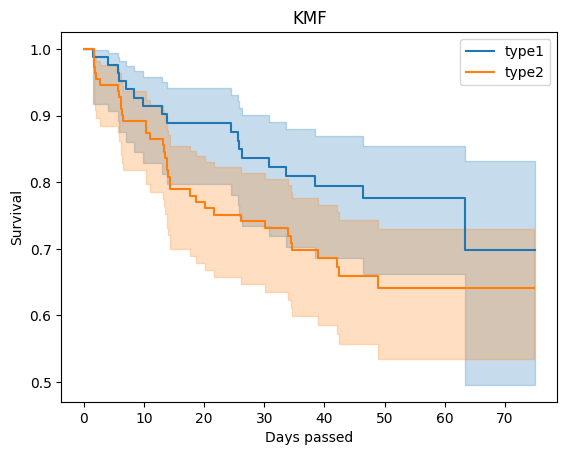

In [33]:
kmf_m.plot()
kmf_f.plot()

plt.xlabel("Days passed")
plt.ylabel("Survival")
plt.title("KMF")

<Axes: xlabel='timeline'>

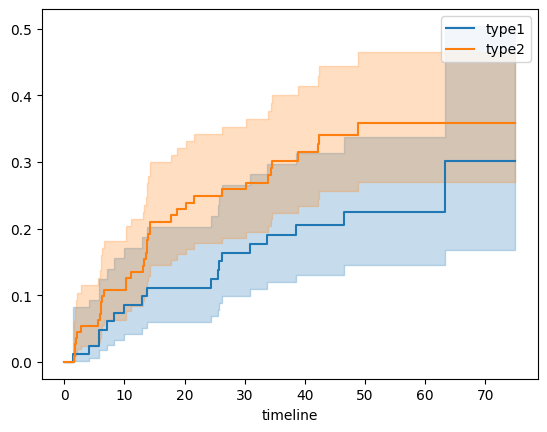

In [34]:
# plot cumulative density

kmf_m.plot_cumulative_density()
kmf_f.plot_cumulative_density()

In [35]:
Time0 = type1['time']
Event0 = type1['status']

Time1 = type2['time']
Event1 = type2['status']


result=logrank_test(Time0,Time1,event_observed_A=Event0,event_observed_B=Event1)
result.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.97 0.09      3.56

From the above curve we can observe that there is difference in the survival time of people who were treated with Xenon or Argon laser.

#### Power of Laser Eye Surgery Data

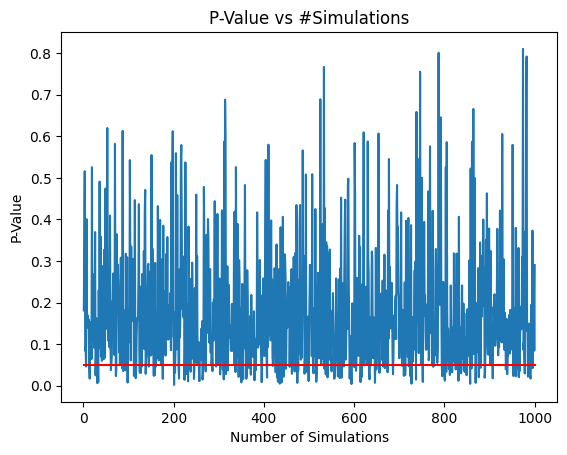

Power of Log-Rank Test : 16.9 %


In [36]:
power=0
p_values=[]
n_simulations=1000
for i in range(n_simulations):
    selected_rows = data.sample(n=150, replace=False)
    type1=selected_rows.query("gas==0")
    type2=selected_rows.query("gas==1")
    
    Time0 = type1['time']
    Event0 = type1['status']

    Time1 = type2['time']
    Event1 = type2['status']

    result=logrank_test(Time0,Time1,event_observed_A=Event0,event_observed_B=Event1)
    p_values.append(result.p_value)
    if result.p_value < 0.05:
        power += 1
power=power/n_simulations
x=np.linspace(1,n_simulations,n_simulations)
y=[0.05 for _ in range(1000)]
plt.plot(x,p_values)
plt.plot(x,y,color='r')
plt.xlabel('Number of Simulations')
plt.ylabel('P-Value')
plt.title('P-Value vs #Simulations')
plt.show()
print(f"Power of Log-Rank Test : {round(power*100,3)} %")